### Load the data

In [17]:
import torch
from transformer_lens import HookedTransformer, HookedTransformerConfig
from neel_plotly.plot import line
from helpers import loss_fn
from devinterp.slt.sampler import estimate_learning_coeff_with_summary, estimate_learning_coeff, SGLD
from devinterp.utils import plot_trace
import tqdm.auto as tqdm
import os
from pathlib import Path
from helpers import rolling_average

CREATE_ESTIMATES = True
TUNE_HYPERPARAMS = True

device = "cuda" if torch.cuda.is_available() else "cpu"
RAND_SEED = 42

if CREATE_ESTIMATES:
    LOAD_LOCATION = "../saves/check_point_50/grokking_add_multi_0.65.pth"

    cached_data = torch.load(LOAD_LOCATION, weights_only=False)

    state_dict = cached_data['model']
    model_checkpoints = cached_data["checkpoints"]
    checkpoint_epochs = cached_data["checkpoint_epochs"]
    test_losses = cached_data['test_losses']
    train_losses = cached_data['train_losses']
    add_test_losses = cached_data['add_test_losses']
    multi_test_losses = cached_data['multi_test_losses']
    max_nums = cached_data['max_nums']
    mod_value = cached_data['mod_value']
    train_frac = cached_data['train_frac']
    addition_frac = cached_data['addition_frac']
    train_data = cached_data['train_data']
    train_labels = cached_data['train_labels']

    # print(f"train_frac = {train_frac} addition_frac = {addition_frac}")
    print(f"len(train_losses) = {len(train_losses)} len(test_losses) = {len(test_losses)} len(model_checkpoints) = {len(model_checkpoints)}")
    print(f"train_data.shape = {train_data.shape} train_labels.shape = {train_labels.shape}")
    print(f"train_data[:5] = {train_data[:5]} train_labels[:5] = {train_labels[:5]}")

len(train_losses) = 6000 len(test_losses) = 6000 len(model_checkpoints) = 120
train_data.shape = torch.Size([16900, 3]) train_labels.shape = torch.Size([16900])
train_data[:5] = tensor([[ 71,   0,  13],
        [ 65,   0,   0],
        [121,   1,  24],
        [ 26,   0,  77],
        [ 42,   1,  35]]) train_labels[:5] = tensor([19,  0, 32, 81, 77])


In [2]:
from torch.utils.data import TensorDataset, DataLoader
if CREATE_ESTIMATES:
    train_loader = DataLoader(TensorDataset(train_data, train_labels), batch_size=32, shuffle=True)
    print(f"train_loader = {len(train_loader)}")

train_loader = 529


### Setup the Model

In [3]:
if CREATE_ESTIMATES:
    cfg = HookedTransformerConfig(
        n_layers = 1,
        n_heads = 4,
        d_model = 128,
        d_head = 32,
        d_mlp = 512,
        act_fn = "relu",
        normalization_type= "LN" if "blocks.0.ln1.w" in state_dict else None,
        d_vocab=max_nums+1,
        d_vocab_out=mod_value,
        n_ctx= train_data.shape[1],
        init_weights=True,
        device=device,
        seed = RAND_SEED,
    )

    model = HookedTransformer(cfg)

### Local Learning Coefficient (RLCT) Estimation

#### Config

In [102]:
lr = 3e-2
num_chains = 3
num_draws = 150
num_burnin_steps = 50
num_steps_bw_draws = 1
gamma = 10
nbeta = 1.6
sampling_method = "sgld"

def evaluate(model, data):
    inputs, outputs = data

    return loss_fn(model(inputs), outputs), {
        "logits": model(inputs)
    }

#### Find the right hyperparameters

In [9]:
import typing
from typing import Type

import numpy as np


def estimate_llc_given_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    evaluate: typing.Callable,
    epsilon: float,
    beta: float,
    sampling_method: Type[torch.optim.Optimizer] = SGLD,
    localization: float = 5.0,
    num_chains: int = 3,
    num_draws: int = 500,
    num_burnin_steps: int = 0,
    num_steps_bw_draws: int = 1,
    device: torch.device = torch.device("cpu"),
    online: bool = True,
    verbose: bool = False,
):

    sweep_stats = estimate_learning_coeff_with_summary(
        model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=sampling_method,
        optimizer_kwargs=dict(lr=epsilon, localization=localization, nbeta=beta),
        num_chains=num_chains,  # How many independent chains to run
        num_draws=num_draws,  # How many samples to draw per chain
        num_burnin_steps=num_burnin_steps,  # How many samples to discard at the beginning of each chain
        num_steps_bw_draws=num_steps_bw_draws,  # How many steps to take between each sample
        device=device,
        online=online,
        verbose=verbose,
    )

    sweep_stats["llc/trace"] = np.array(sweep_stats["llc/trace"])
    return sweep_stats

In [14]:
from devinterp.vis_utils import EpsilonBetaAnalyzer

if TUNE_HYPERPARAMS:
    model.load_state_dict(state_dict)
    analyzer = EpsilonBetaAnalyzer()
    analyzer.configure_sweep(
        llc_estimator=estimate_llc_given_model,
        llc_estimator_kwargs=dict(
            model=model,
            evaluate=evaluate,
            device=device,
            loader=train_loader,
        ),
        min_epsilon=3e-5,
        max_epsilon=3e-1,
        epsilon_samples=5,
        min_beta=None,
        max_beta=None,
        beta_samples=5,
        dataloader=train_loader,
    )
    analyzer.sweep()
    analyzer.plot()

/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/vis_utils.py:86: UserWarning:

Epsilon values greater than 1e-2 typically lead to instability in the sampling process. Consider reducing epsilon to between 1e-6 and 1e-2.

  0%|          | 0/25 [00:00<?, ?it/s]/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/slt/sampler.py:118: UserWarning:

Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.

/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:232: UserWarning:

You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.

/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:277: UserWarning:

If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in th

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


  4%|▍         | 1/25 [00:07<02:53,  7.24s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


  8%|▊         | 2/25 [00:14<02:49,  7.39s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 12%|█▏        | 3/25 [00:22<02:46,  7.56s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 16%|█▌        | 4/25 [00:29<02:37,  7.50s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 20%|██        | 5/25 [00:37<02:33,  7.66s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 24%|██▍       | 6/25 [00:45<02:24,  7.61s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 28%|██▊       | 7/25 [00:52<02:14,  7.45s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 32%|███▏      | 8/25 [00:59<02:06,  7.43s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 36%|███▌      | 9/25 [01:07<01:57,  7.36s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 40%|████      | 10/25 [01:14<01:52,  7.50s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 44%|████▍     | 11/25 [01:22<01:46,  7.62s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 48%|████▊     | 12/25 [01:30<01:38,  7.59s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 52%|█████▏    | 13/25 [01:38<01:31,  7.63s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 56%|█████▌    | 14/25 [01:45<01:24,  7.69s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 60%|██████    | 15/25 [01:53<01:17,  7.70s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 64%|██████▍   | 16/25 [02:01<01:08,  7.62s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 68%|██████▊   | 17/25 [02:09<01:02,  7.79s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 72%|███████▏  | 18/25 [02:16<00:53,  7.70s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 76%|███████▌  | 19/25 [02:24<00:45,  7.65s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 80%|████████  | 20/25 [02:31<00:38,  7.63s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 84%|████████▍ | 21/25 [02:39<00:30,  7.69s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 88%|████████▊ | 22/25 [02:47<00:23,  7.70s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 92%|█████████▏| 23/25 [02:55<00:15,  7.72s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


 96%|█████████▌| 24/25 [03:02<00:07,  7.67s/it]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


100%|██████████| 25/25 [03:11<00:00,  7.65s/it]


In [13]:
if TUNE_HYPERPARAMS:
    print(TUNE_HYPERPARAMS)
    analyzer.plot()

True


nbeta = 1.6 gamma = 10 lr = 0.03
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:00<00:00, 225.33it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:00<00:00, 205.23it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:00<00:00, 229.24it/s]


results.keys() = dict_keys(['init_loss', 'llc/means', 'llc/stds', 'llc/trace', 'loss/trace'])
results['llc/trace'].shape = (3, 150)


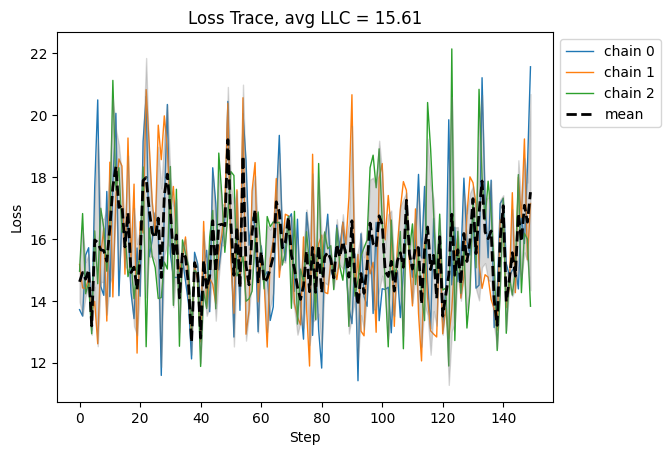

<Figure size 1200x900 with 0 Axes>

In [103]:
if TUNE_HYPERPARAMS:
    print(f"nbeta = {nbeta} gamma = {gamma} lr = {lr}")

    model.load_state_dict(state_dict=state_dict)

    results = estimate_learning_coeff_with_summary(
                    model,
                    loader=train_loader,
                    evaluate=evaluate,
                    sampling_method=SGLD if sampling_method == "sgld" else None,
                    optimizer_kwargs=dict(lr=lr, nbeta=nbeta, localization=gamma),
                    num_chains=num_chains,                  # How many independent chains to run
                    num_draws=num_draws,                    # How many samples to draw per chain
                    num_burnin_steps=num_burnin_steps,      # How many samples to discard at the beginning of each chain
                    num_steps_bw_draws=num_steps_bw_draws,  # How many steps to take between each sample
                    device=device,
                    online=True,
                )
    print(f"results.keys() = {results.keys()}")
    print(f"results['llc/trace'].shape = {results['llc/trace'].shape}")

    plot_trace(
        results["llc/trace"],
        "Loss",
        x_axis="Step",
        title=f"Loss Trace, avg LLC = {sum(results['llc/means']) / len(results['llc/means']):.2f}",
        plot_mean=False,
        plot_std=False,
        fig_size=(12, 9),
        true_lc=None,
    )

### Estimate for model checkpoints

In [104]:
from devinterp.slt.sampler import estimate_learning_coeff_with_summary, estimate_learning_coeff, SGLD
from devinterp.utils import plot_trace

def evaluate(model, data):
    inputs, outputs = data

    return loss_fn(model(inputs), outputs), {
        "logits": model(inputs)
    }

if CREATE_ESTIMATES:
    # print(f"Addition frac = {addition_frac} Train frac = {train_frac}")
    print(f"nbeta = {nbeta} gamma = {gamma} lr = {lr}")
    llc_estimates = []

    for saved_model in tqdm.tqdm(model_checkpoints):
        model.load_state_dict(saved_model)
        result = estimate_learning_coeff_with_summary(
                    model,
                    loader=train_loader,
                    evaluate=evaluate,
                    sampling_method=SGLD if sampling_method == "sgld" else None,
                    optimizer_kwargs=dict(lr=lr, nbeta=nbeta, localization=gamma),
                    num_chains=num_chains,                  # How many independent chains to run
                    num_draws=num_draws,                    # How many samples to draw per chain
                    num_burnin_steps=num_burnin_steps,      # How many samples to discard at the beginning of each chain
                    num_steps_bw_draws=num_steps_bw_draws,  # How many steps to take between each sample
                    device=device,
                    online=False,
                )
        print(f"result['llc/mean'] = {result["llc/mean"]}")
        llc_estimates.append(result["llc/mean"])

nbeta = 1.6 gamma = 10 lr = 0.03


  0%|          | 0/120 [00:00<?, ?it/s]

Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:00<00:00, 210.76it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:00<00:00, 225.88it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:00<00:00, 219.68it/s]


result['llc/mean'] = 10.302932739257812
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:00<00:00, 203.21it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:00<00:00, 220.84it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:00<00:00, 220.85it/s]


result['llc/mean'] = 13.174630165100098
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:00<00:00, 205.34it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:00<00:00, 210.08it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 189.02it/s]


result['llc/mean'] = 15.244574546813965
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 181.42it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 155.99it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 176.20it/s]


result['llc/mean'] = 16.72515296936035
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:00<00:00, 201.69it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 184.23it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 192.71it/s]


result['llc/mean'] = 17.171079635620117
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 180.89it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 199.44it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 186.54it/s]


result['llc/mean'] = 17.497774124145508
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 199.18it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 199.92it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 197.19it/s]


result['llc/mean'] = 17.9674072265625
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:00<00:00, 206.41it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:00<00:00, 207.65it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 193.91it/s]


result['llc/mean'] = 16.957984924316406
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:00<00:00, 202.98it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:00<00:00, 206.71it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 196.22it/s]


result['llc/mean'] = 16.322616577148438
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:00<00:00, 206.00it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:00<00:00, 204.27it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 196.89it/s]


result['llc/mean'] = 17.370691299438477
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:00<00:00, 205.32it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:00<00:00, 202.92it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 190.66it/s]


result['llc/mean'] = 16.848756790161133
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:00<00:00, 203.97it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:00<00:00, 202.26it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 194.53it/s]


result['llc/mean'] = 16.682950973510742
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 182.34it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 142.10it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 140.76it/s]


result['llc/mean'] = 17.45859146118164
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 180.41it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 191.51it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 198.22it/s]


result['llc/mean'] = 16.37970733642578
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 188.91it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:00<00:00, 200.18it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 192.91it/s]


result['llc/mean'] = 16.682373046875
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 188.70it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 197.79it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 180.44it/s]


result['llc/mean'] = 15.76213550567627
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 152.29it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 154.33it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 178.54it/s]


result['llc/mean'] = 17.77276039123535
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 179.32it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 179.44it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 170.62it/s]


result['llc/mean'] = 16.478158950805664
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 151.32it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 175.71it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 137.47it/s]


result['llc/mean'] = 16.20326805114746
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 160.31it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 180.83it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 181.52it/s]


result['llc/mean'] = 16.176368713378906
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 195.55it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 191.11it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 195.92it/s]


result['llc/mean'] = 17.043642044067383
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 180.23it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 189.75it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 172.14it/s]


result['llc/mean'] = 13.77685260772705
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 166.39it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 149.39it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 182.19it/s]


result['llc/mean'] = 16.902502059936523
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 178.01it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 179.19it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 176.48it/s]


result['llc/mean'] = 15.758903503417969
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 180.04it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 191.06it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 171.25it/s]


result['llc/mean'] = 16.41139030456543
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 188.54it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 180.98it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 156.12it/s]


result['llc/mean'] = 15.535897254943848
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 180.70it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 186.84it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 195.35it/s]


result['llc/mean'] = 15.830024719238281
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 192.00it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 179.94it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 190.83it/s]


result['llc/mean'] = 15.762089729309082
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 186.88it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 185.77it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 194.54it/s]


result['llc/mean'] = 15.281391143798828
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 185.93it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 192.29it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 180.05it/s]


result['llc/mean'] = 16.03111457824707
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 184.68it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 188.35it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 191.91it/s]


result['llc/mean'] = 15.278111457824707
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 186.30it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 194.01it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 185.79it/s]


result['llc/mean'] = 15.582649230957031
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 193.68it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 193.78it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 185.06it/s]


result['llc/mean'] = 15.076255798339844
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 190.94it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 190.50it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 184.48it/s]


result['llc/mean'] = 14.949244499206543
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 191.31it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 178.97it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 193.69it/s]


result['llc/mean'] = 15.238480567932129
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 190.84it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 181.35it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 192.25it/s]


result['llc/mean'] = 14.773601531982422
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 193.33it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 189.95it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 192.67it/s]


result['llc/mean'] = 14.649612426757812
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 182.44it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 168.51it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 143.88it/s]


result['llc/mean'] = 14.872143745422363
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 147.68it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 172.09it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 169.30it/s]


result['llc/mean'] = 15.205418586730957
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 185.13it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 192.46it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 183.76it/s]


result['llc/mean'] = 15.16653823852539
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 192.58it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 191.45it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 171.97it/s]


result['llc/mean'] = 15.420411109924316
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 188.74it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 181.37it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 188.66it/s]


result['llc/mean'] = 15.050052642822266
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 175.73it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 189.44it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 191.10it/s]


result['llc/mean'] = 15.393771171569824
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 187.76it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 188.78it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 178.88it/s]


result['llc/mean'] = 14.945549011230469
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 188.93it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 185.39it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 183.67it/s]


result['llc/mean'] = 14.391409873962402
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 192.16it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 182.71it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 181.19it/s]


result['llc/mean'] = 14.754768371582031
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 187.79it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 175.39it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 182.39it/s]


result['llc/mean'] = 15.049995422363281
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 188.60it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 184.01it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 192.78it/s]


result['llc/mean'] = 15.678149223327637
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 190.74it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 185.28it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 192.24it/s]


result['llc/mean'] = 14.72435474395752
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 181.98it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 189.09it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 187.13it/s]


result['llc/mean'] = 14.932755470275879
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 182.80it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 192.39it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 180.57it/s]


result['llc/mean'] = 15.163841247558594
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 190.43it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 190.82it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 182.40it/s]


result['llc/mean'] = 15.145377159118652
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 190.89it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 190.59it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 185.46it/s]


result['llc/mean'] = 15.006356239318848
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 190.37it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 183.52it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 191.55it/s]


result['llc/mean'] = 15.166975975036621
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 190.38it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 181.35it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 189.34it/s]


result['llc/mean'] = 15.228690147399902
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 189.96it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 182.06it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 169.07it/s]


result['llc/mean'] = 15.417094230651855
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 178.29it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 186.02it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 187.31it/s]


result['llc/mean'] = 15.535656929016113
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 177.53it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 175.89it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 186.37it/s]


result['llc/mean'] = 15.496482849121094
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 181.80it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 191.87it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 182.88it/s]


result['llc/mean'] = 15.063194274902344
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 191.32it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 189.28it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 173.33it/s]


result['llc/mean'] = 15.214644432067871
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 188.21it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 189.79it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 169.58it/s]


result['llc/mean'] = 15.059834480285645
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 172.85it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 178.44it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 190.10it/s]


result['llc/mean'] = 14.79272747039795
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 191.47it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 184.82it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 193.18it/s]


result['llc/mean'] = 15.008587837219238
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 182.66it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 174.19it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 168.11it/s]


result['llc/mean'] = 14.95456600189209
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 175.71it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 167.00it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 121.91it/s]


result['llc/mean'] = 15.128018379211426
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 168.09it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 170.08it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 175.35it/s]


result['llc/mean'] = 15.278109550476074
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 185.39it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 190.52it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 148.90it/s]


result['llc/mean'] = 15.290367126464844
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 172.17it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 171.35it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 163.53it/s]


result['llc/mean'] = 15.442782402038574
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 172.11it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 165.08it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 174.27it/s]


result['llc/mean'] = 15.672471046447754
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 161.01it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 160.59it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 161.27it/s]


result['llc/mean'] = 15.842913627624512
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 161.52it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 164.54it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 142.86it/s]


result['llc/mean'] = 15.796114921569824
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 164.70it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 164.64it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 163.07it/s]


result['llc/mean'] = 15.668566703796387
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 185.65it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 175.07it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 194.06it/s]


result['llc/mean'] = 15.291423797607422
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 193.84it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 185.43it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 188.09it/s]


result['llc/mean'] = 15.038166999816895
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 181.05it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 185.35it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 185.80it/s]


result['llc/mean'] = 14.780251502990723
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 168.49it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 168.65it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 184.05it/s]


result['llc/mean'] = 14.583212852478027
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 176.62it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 141.73it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 107.61it/s]


result['llc/mean'] = 14.661331176757812
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 141.64it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 175.42it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 188.04it/s]


result['llc/mean'] = 14.824851989746094
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 188.67it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 178.72it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 191.98it/s]


result['llc/mean'] = 14.664395332336426
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 189.49it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 186.21it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 184.84it/s]


result['llc/mean'] = 14.94005298614502
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 177.42it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 187.51it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 186.25it/s]


result['llc/mean'] = 15.197358131408691
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 180.06it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 187.99it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 180.06it/s]


result['llc/mean'] = 14.899834632873535
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 183.88it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 182.80it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 179.75it/s]


result['llc/mean'] = 15.186718940734863
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 191.06it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 191.00it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 188.09it/s]


result['llc/mean'] = 15.381834983825684
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 192.74it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 184.31it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 189.20it/s]


result['llc/mean'] = 15.33126449584961
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 192.57it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 182.37it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 191.77it/s]


result['llc/mean'] = 15.4700927734375
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 190.11it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 185.14it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 188.63it/s]


result['llc/mean'] = 15.332919120788574
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 191.81it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 185.81it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 193.54it/s]


result['llc/mean'] = 15.647309303283691
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 191.62it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 183.55it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 189.86it/s]


result['llc/mean'] = 15.45340633392334
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 188.31it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 183.63it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 190.41it/s]


result['llc/mean'] = 14.990099906921387
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 185.74it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 193.83it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 192.36it/s]


result['llc/mean'] = 14.588021278381348
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 183.96it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 191.20it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 189.67it/s]


result['llc/mean'] = 14.39409351348877
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 185.58it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 193.16it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 191.39it/s]


result['llc/mean'] = 14.461377143859863
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 185.70it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 190.50it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 185.39it/s]


result['llc/mean'] = 14.35842514038086
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 168.18it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 182.59it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 171.06it/s]


result['llc/mean'] = 14.444903373718262
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 178.22it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 177.43it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 181.93it/s]


result['llc/mean'] = 14.65512466430664
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 194.64it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 194.20it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 178.47it/s]


result['llc/mean'] = 14.86920166015625
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 191.64it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 184.41it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 193.44it/s]


result['llc/mean'] = 14.888473510742188
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 192.48it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 185.42it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 193.92it/s]


result['llc/mean'] = 15.282024383544922
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 190.47it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 183.89it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 192.56it/s]


result['llc/mean'] = 15.260571479797363
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 193.37it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 183.35it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 191.99it/s]


result['llc/mean'] = 15.412800788879395
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 193.66it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 186.07it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 190.92it/s]


result['llc/mean'] = 15.121315956115723
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 192.16it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 184.22it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 191.58it/s]


result['llc/mean'] = 15.391463279724121
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 184.34it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 192.62it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 190.07it/s]


result['llc/mean'] = 15.515331268310547
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 184.71it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 191.28it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 189.20it/s]


result['llc/mean'] = 15.207749366760254
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 184.64it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 192.00it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 190.95it/s]


result['llc/mean'] = 14.837753295898438
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 185.17it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 187.94it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 190.62it/s]


result['llc/mean'] = 14.485867500305176
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 184.86it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 189.98it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 191.11it/s]


result['llc/mean'] = 14.283759117126465
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 183.85it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 189.93it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 183.81it/s]


result['llc/mean'] = 14.434181213378906
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 190.84it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 192.37it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 183.86it/s]


result['llc/mean'] = 14.410991668701172
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 192.35it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 191.86it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 184.31it/s]


result['llc/mean'] = 14.58901596069336
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 189.82it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 193.28it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 184.50it/s]


result['llc/mean'] = 14.659274101257324
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 191.22it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 191.80it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 184.81it/s]


result['llc/mean'] = 14.83530330657959
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 191.86it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 183.67it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 191.56it/s]


result['llc/mean'] = 14.908058166503906
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 190.76it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 185.37it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 190.21it/s]


result['llc/mean'] = 14.8291597366333
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 182.94it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 188.75it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 184.68it/s]


result['llc/mean'] = 15.22921371459961
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 183.47it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 190.37it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 192.85it/s]


result['llc/mean'] = 15.052351951599121
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 179.30it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 190.28it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 190.52it/s]


result['llc/mean'] = 15.757048606872559
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 184.78it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 193.02it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 191.14it/s]


result['llc/mean'] = 15.403071403503418
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 188.78it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:01<00:00, 192.09it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:01<00:00, 184.47it/s]

result['llc/mean'] = 15.574091911315918


### Save the data

In [314]:
SAVE_LOCATION = "../saves/check_point_50/llc_estimates_0.3.pth"

if CREATE_ESTIMATES:
    os.makedirs(Path(SAVE_LOCATION).parent, exist_ok=True)
    torch.save({
        "llc_estimates": llc_estimates,
        "lr": lr,
        "nbeta": nbeta,
        "gamma": gamma,
        "num_chains": num_chains,
        "num_draws": num_draws,
        "num_burnin_steps": num_burnin_steps,
        "num_steps_bw_draws": num_steps_bw_draws,
        "sampling_method": sampling_method,
        "train_frac": train_frac,
        "addition_frac": addition_frac,
        "LOAD_LOCATION": LOAD_LOCATION,
    }, SAVE_LOCATION)
    print(f"addition_frac = {addition_frac} train_frac = {train_frac}")
    print(f"Saved to {SAVE_LOCATION}")

addition_frac = 0.3 train_frac = 0.5
Saved to ../saves/check_point_50/llc_estimates_0.3.pth


### Load data

In [10]:
LOAD_DATA_PATH = "../saves/check_point_50/llc_estimates_0.5.pth"
if not CREATE_ESTIMATES:
    cached_data = torch.load(LOAD_DATA_PATH, weights_only=False)
    llc_estimates = cached_data['llc_estimates']
    lr = cached_data['lr']
    nbeta = cached_data['nbeta']
    gamma = cached_data['gamma']
    num_chains = cached_data['num_chains']
    num_draws = cached_data['num_draws']
    num_burnin_steps = cached_data['num_burnin_steps']
    num_steps_bw_draws = cached_data['num_steps_bw_draws']
    sampling_method = cached_data['sampling_method']
    train_frac = cached_data['train_frac']
    addition_frac = cached_data['addition_frac']
    training_data_path = cached_data['LOAD_LOCATION']
    print(f"addition_frac = {addition_frac} train_frac = {train_frac} len(llc_estimates) = {len(llc_estimates)}")
    print(f"Estimate created from {training_data_path}")

    training_data = torch.load(training_data_path, weights_only=False)
    train_losses = training_data['train_losses']
    test_losses = training_data['test_losses']
    add_test_losses = training_data['add_test_losses']
    multi_test_losses = training_data['multi_test_losses']
    print(f"len(train_losses) = {len(train_losses)} len(test_losses) = {len(test_losses)}")

addition_frac = 0.5 train_frac = 0.5 len(llc_estimates) = 120
Estimate created from ../saves/check_point_50/grokking_add_multi_0.5.pth
len(train_losses) = 6000 len(test_losses) = 6000


## Make some cool graphs

In [106]:
average_window = 5
llc_estimates_avg = rolling_average(llc_estimates, average_window)
line(llc_estimates, xaxis="Checkpoint", yaxis="LLC", title=f"LLC - addition_frac = {addition_frac} nbeta = {nbeta} epsilon = {lr} gamma = {gamma}", log_y=False, toggle_x=True, toggle_y=True)
line(llc_estimates_avg, xaxis="Checkpoint", yaxis="Rolling Average LLC", title="Learning Coefficient Estimates", log_y=False, toggle_x=True, toggle_y=True)